In [5]:
#Gerekli kütüphaneler yüklendi
!pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud keras tensorflow

In [17]:
#Kütüphaneler içe aktarıldı
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from wordcloud import WordCloud
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\damml\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\damml\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\damml\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [11]:
#Veri seti yüklendi
df = pd.read_csv('sentiment140.csv', encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

#Veri setinin boyutu ve ilk 5 satırı
print(f"Veri seti boyutu: {df.shape}")
df.head()


Veri seti boyutu: (1600000, 6)


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
#Hedef sınıflar ve eksik veri kontrolü
print("Hedef sınıflar:", df['target'].unique())
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)
print("Eksik veri kontrolü:\n", df.isnull().sum())


Hedef sınıflar: [0 4]
Eksik veri kontrolü:
 target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64


In [16]:
#Metin temizleme fonksiyonu
stop_words = set(stopwords.words('english'))
def temizle_metni(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

df['clean_text'] = df['text'].apply(temizle_metni)
df[['text', 'clean_text']].head()


,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",thats bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


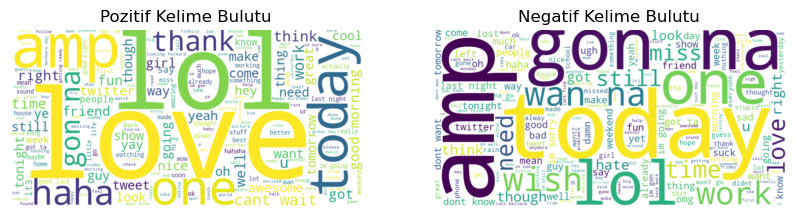

In [20]:
#Kelime bulutları oluşturuldu
pozitif_text = " ".join(df[df['target'] == 1]['clean_text'])
negatif_text = " ".join(df[df['target'] == 0]['clean_text'])

wordcloud_pozitif = WordCloud(width=800, height=400, background_color='white').generate(pozitif_text)
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(negatif_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pozitif, interpolation='bilinear')
plt.title('Pozitif Kelime Bulutu')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.title('Negatif Kelime Bulutu')
plt.axis('off')
plt.show()


In [22]:
#Eğitim ve test setleri ayrıldı
X = df['clean_text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Eğitim seti boyutu: {X_train.shape[0]}")
print(f"Test seti boyutu: {X_test.shape[0]}")


Eğitim seti boyutu: 1280000
Test seti boyutu: 320000


In [24]:
#TF-IDF vektörizer ile metni sayısallaştırma yapıldı
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print(f"TF-IDF vektör boyutu: {X_train_tfidf.shape}")


TF-IDF vektör boyutu: (1280000, 5000)


In [26]:
#Lojistik regresyon modeli
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print("Doğruluk Skoru:", accuracy_score(y_test, y_pred))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))


Doğruluk Skoru: 0.77346875

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



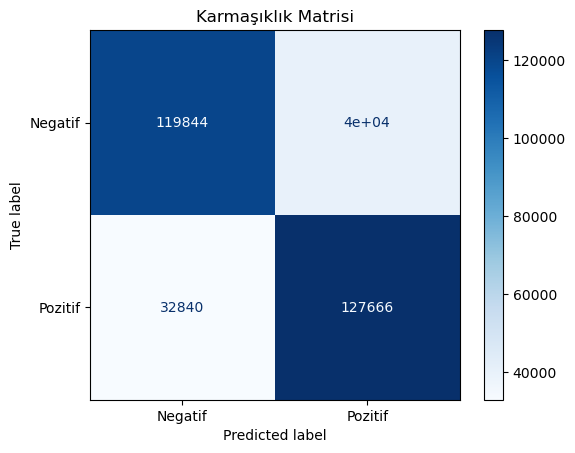

In [28]:
#Karmaşıklık matrisi
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatif', 'Pozitif'])
disp.plot(cmap='Blues')
plt.title('Karmaşıklık Matrisi')
plt.show()


C:\Users\damml\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1434s 36ms/step - accuracy: 0.7665 - loss: 0.4809 - val_accuracy: 0.7883 - val_loss: 0.4481
Epoch 2/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1487s 37ms/step - accuracy: 0.7927 - loss: 0.4401 - val_accuracy: 0.7918 - val_loss: 0.4419
Epoch 3/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1507s 38ms/step - accuracy: 0.8009 - loss: 0.4263 - val_accuracy: 0.7914 - val_loss: 0.4422
Epoch 4/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1470s 37ms/step - accuracy: 0.8063 - loss: 0.4173 - val_accuracy: 0.7921 - val_loss: 0.4435
Epoch 5/5
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1477s 37ms/step - accuracy: 0.8122 - loss: 0.4073 - val_accuracy: 0.7923 - val_loss: 0.4432


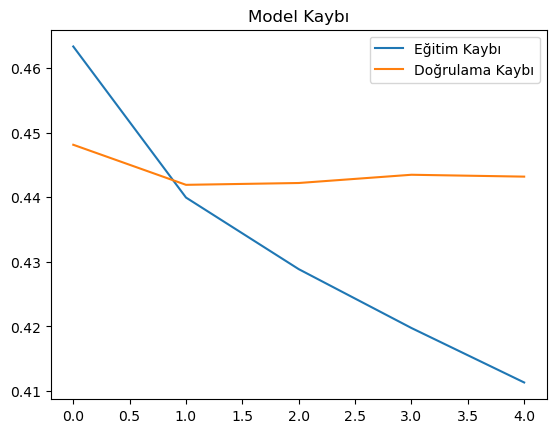

In [30]:
#Tokenization ve padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

#LSTM modeli
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Modeli eğitme
history = model_lstm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=32)

#Eğitim ve doğrulama kayıplarını görselleştirme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()
plt.show()


In [38]:
from sklearn.metrics import accuracy_score

y_pred = (model_lstm.predict(X_test_pad) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"LSTM Model Doğruluk Oranı: {accuracy * 100:.2f}%")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 103s 10ms/step
LSTM Model Doğruluk Oranı: 79.23%


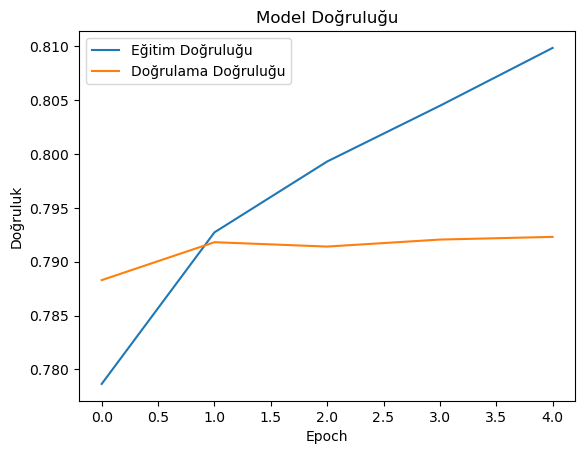

In [32]:
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 126s 13ms/step


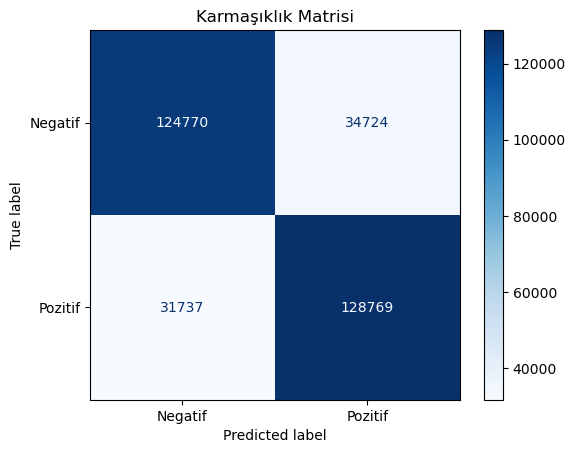

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (model_lstm.predict(X_test_pad) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatif', 'Pozitif'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Karmaşıklık Matrisi')
plt.show()


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 125s 13ms/step


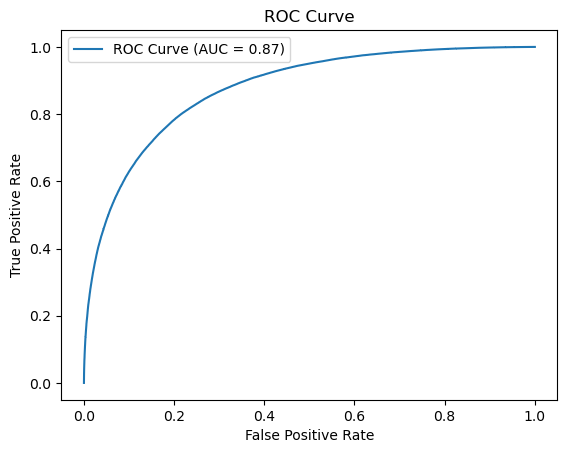

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = model_lstm.predict(X_test_pad).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
